# In this notebook, I will create better maps to analyze the changes in rent burden within Alameda County Census Block Group.


In this notebook, I hope to show if the changes in rent burden in census block groups in Alameda county are statistically significant. I also hope to project our BART stations onto the same maps so that we can see the changes in relation to our focus TOD BART stops and our non TOD control BART stops.

I have cleaned the datasets for all these variables in previous notebooks, so I will not go through that again here. Instead, I'll directly load my saved, cleaned datasets into this notebook so we can jump right to it.

In [1]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px


/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
stations = gpd.read_file('Data/new_stations.geojson')

In [3]:
stations.head(10)

,Station,City,Code,TOD,County,Marker,lon,lat,geometry
0,ASHBY,Berkeley,BKY,Yes,ALA,D,-122.270119,37.853207,POINT (-122.27012 37.85321)
1,MACARTHUR,Oakland,OAK,Yes,ALA,D,-122.267120,37.828705,POINT (-122.26712 37.82871)
2,HAYWARD,Hayward,HAY,Yes,ALA,D,-122.087204,37.670124,POINT (-122.08720 37.67012)
3,SOUTH HAYWARD,Hayward,HAY,Yes,ALA,D,-122.057037,37.634483,POINT (-122.05704 37.63448)
4,FRUITVALE,Oakland,OAK,Yes,ALA,D,-122.224197,37.774559,POINT (-122.22420 37.77456)
5,NORTH BERKELEY,Berkeley,BKY,No,ALA,o,-122.283348,37.874061,POINT (-122.28335 37.87406)
6,19TH STREET/OAKLAND,Oakland,OAK,No,ALA,o,-122.268387,37.808075,POINT (-122.26839 37.80808)
7,BAY FAIR,San Leandro,SAN,No,ALA,o,-122.127060,37.697566,POINT (-122.12706 37.69757)
8,UNION CITY,Union City,UNC,No,ALA,o,-122.017151,37.590865,POINT (-122.01715 37.59087)
9,LAKE MERRITT,Oakland,OAK,No,ALA,o,-122.265541,37.797679,POINT (-122.26554 37.79768)


In [4]:
blkgrp = gpd.read_file('Data/Alameda_BG.geojson')
blkgrp.head(2)

,GEOID,Total,geometry
0,060014403351,79,"POLYGON ((-13583031.833 4522484.609, -13583027..."
1,060014423012,301,"POLYGON ((-13577280.177 4513283.384, -13577279..."


In [5]:
rent_b = gpd.read_file('Data/RB_focus.geojson')
rent_b.head()

,GEOID,Name,<10%_change,>50%_change,>30%_change,geometry
0,060014013002,"Block Group 2, Census Tract 4013, Alameda Coun...",-0.317572,0.765584,0.020955,"POLYGON ((-122.27339 37.81272, -122.27320 37.8..."
1,060014013003,"Block Group 3, Census Tract 4013, Alameda Coun...",-0.234168,-0.489111,-0.020097,"POLYGON ((-122.26903 37.81209, -122.26893 37.8..."
2,060014052004,"Block Group 4, Census Tract 4052, Alameda Coun...",0.599206,-0.464266,2.256566,"POLYGON ((-122.25060 37.80524, -122.25047 37.8..."
3,060014223001,"Block Group 1, Census Tract 4223, Alameda Coun...",2.165468,11.068345,-0.502061,"POLYGON ((-122.28279 37.87666, -122.28261 37.8..."
4,060014280002,"Block Group 2, Census Tract 4280, Alameda Coun...",-0.804639,0.954388,0.161428,"POLYGON ((-122.25396 37.76680, -122.25387 37.7..."


In [6]:
stations_wb = stations.to_crs(epsg=3857)
blkgrp_wb = blkgrp.to_crs(epsg=3857)
rent_b_wb = rent_b.to_crs(epsg=3857)

I want to get the bounding box coordinates of the bart stations so that I can use those limits to zoom into these areas for my other maps. This way, we will be able to see the block groups close to the stations and see if there has been changes in the block group population's percent of rent burden. 

When I tried to use the total bounds for the stations variable that wasn't projected onto web mercator, the map didn't work. I figured out I needed to use the stations_wb total bounds to get them on my map correctly. 


In [7]:
# get the bounding box coordinates for the BART stops
minx, miny, maxx, maxy = stations_wb.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13612520.0187
-13582887.1208
4521788.913699999
4561650.127999999


I realize these coordinates have different lat and lon information. I need to fix this so I can do something with the points later.

In [8]:
stations_wb.head(10)

,Station,City,Code,TOD,County,Marker,lon,lat,geometry
0,ASHBY,Berkeley,BKY,Yes,ALA,D,-122.270119,37.853207,POINT (-13611047.382 4558709.643)
1,MACARTHUR,Oakland,OAK,Yes,ALA,D,-122.267120,37.828705,POINT (-13610713.588 4555255.762)
2,HAYWARD,Hayward,HAY,Yes,ALA,D,-122.087204,37.670124,POINT (-13590685.395 4532929.631)
3,SOUTH HAYWARD,Hayward,HAY,Yes,ALA,D,-122.057037,37.634483,POINT (-13587327.220 4527918.437)
4,FRUITVALE,Oakland,OAK,Yes,ALA,D,-122.224197,37.774559,POINT (-13605935.379 4547627.392)
5,NORTH BERKELEY,Berkeley,BKY,No,ALA,o,-122.283348,37.874061,POINT (-13612520.019 4561650.128)
6,19TH STREET/OAKLAND,Oakland,OAK,No,ALA,o,-122.268387,37.808075,POINT (-13610854.531 4552348.671)
7,BAY FAIR,San Leandro,SAN,No,ALA,o,-122.127060,37.697566,POINT (-13595122.116 4536789.751)
8,UNION CITY,Union City,UNC,No,ALA,o,-122.017151,37.590865,POINT (-13582887.121 4521788.914)
9,LAKE MERRITT,Oakland,OAK,No,ALA,o,-122.265541,37.797679,POINT (-13610537.751 4550883.966)


See how the lat and lon are different than the geometry? I need to update them.


In [9]:
stations_wb['lon']=stations_wb.geometry.x
stations_wb['lat']=stations_wb.geometry.y

In [10]:
stations_wb.head()

,Station,City,Code,TOD,County,Marker,lon,lat,geometry
0,ASHBY,Berkeley,BKY,Yes,ALA,D,-1.361105e+07,4.558710e+06,POINT (-13611047.382 4558709.643)
1,MACARTHUR,Oakland,OAK,Yes,ALA,D,-1.361071e+07,4.555256e+06,POINT (-13610713.588 4555255.762)
2,HAYWARD,Hayward,HAY,Yes,ALA,D,-1.359069e+07,4.532930e+06,POINT (-13590685.395 4532929.631)
3,SOUTH HAYWARD,Hayward,HAY,Yes,ALA,D,-1.358733e+07,4.527918e+06,POINT (-13587327.220 4527918.437)
4,FRUITVALE,Oakland,OAK,Yes,ALA,D,-1.360594e+07,4.547627e+06,POINT (-13605935.379 4547627.392)


In [11]:
stations_wb['lat'].dtype

dtype('float64')

I want my stations to have different marker types so we can distinguish which are TOD and which are not. I'll do this by creating two new variables.

In [12]:
tod = stations_wb.copy()
brt = stations_wb.copy()
tod.head(10)


,Station,City,Code,TOD,County,Marker,lon,lat,geometry
0,ASHBY,Berkeley,BKY,Yes,ALA,D,-1.361105e+07,4.558710e+06,POINT (-13611047.382 4558709.643)
1,MACARTHUR,Oakland,OAK,Yes,ALA,D,-1.361071e+07,4.555256e+06,POINT (-13610713.588 4555255.762)
2,HAYWARD,Hayward,HAY,Yes,ALA,D,-1.359069e+07,4.532930e+06,POINT (-13590685.395 4532929.631)
3,SOUTH HAYWARD,Hayward,HAY,Yes,ALA,D,-1.358733e+07,4.527918e+06,POINT (-13587327.220 4527918.437)
4,FRUITVALE,Oakland,OAK,Yes,ALA,D,-1.360594e+07,4.547627e+06,POINT (-13605935.379 4547627.392)
5,NORTH BERKELEY,Berkeley,BKY,No,ALA,o,-1.361252e+07,4.561650e+06,POINT (-13612520.019 4561650.128)
6,19TH STREET/OAKLAND,Oakland,OAK,No,ALA,o,-1.361085e+07,4.552349e+06,POINT (-13610854.531 4552348.671)
7,BAY FAIR,San Leandro,SAN,No,ALA,o,-1.359512e+07,4.536790e+06,POINT (-13595122.116 4536789.751)
8,UNION CITY,Union City,UNC,No,ALA,o,-1.358289e+07,4.521789e+06,POINT (-13582887.121 4521788.914)
9,LAKE MERRITT,Oakland,OAK,No,ALA,o,-1.361054e+07,4.550884e+06,POINT (-13610537.751 4550883.966)


In [13]:
tod = tod.drop(tod.index[[5,6,7,8,9]])
tod.head()

,Station,City,Code,TOD,County,Marker,lon,lat,geometry
0,ASHBY,Berkeley,BKY,Yes,ALA,D,-1.361105e+07,4.558710e+06,POINT (-13611047.382 4558709.643)
1,MACARTHUR,Oakland,OAK,Yes,ALA,D,-1.361071e+07,4.555256e+06,POINT (-13610713.588 4555255.762)
2,HAYWARD,Hayward,HAY,Yes,ALA,D,-1.359069e+07,4.532930e+06,POINT (-13590685.395 4532929.631)
3,SOUTH HAYWARD,Hayward,HAY,Yes,ALA,D,-1.358733e+07,4.527918e+06,POINT (-13587327.220 4527918.437)
4,FRUITVALE,Oakland,OAK,Yes,ALA,D,-1.360594e+07,4.547627e+06,POINT (-13605935.379 4547627.392)


In [14]:
brt.head(10)

,Station,City,Code,TOD,County,Marker,lon,lat,geometry
0,ASHBY,Berkeley,BKY,Yes,ALA,D,-1.361105e+07,4.558710e+06,POINT (-13611047.382 4558709.643)
1,MACARTHUR,Oakland,OAK,Yes,ALA,D,-1.361071e+07,4.555256e+06,POINT (-13610713.588 4555255.762)
2,HAYWARD,Hayward,HAY,Yes,ALA,D,-1.359069e+07,4.532930e+06,POINT (-13590685.395 4532929.631)
3,SOUTH HAYWARD,Hayward,HAY,Yes,ALA,D,-1.358733e+07,4.527918e+06,POINT (-13587327.220 4527918.437)
4,FRUITVALE,Oakland,OAK,Yes,ALA,D,-1.360594e+07,4.547627e+06,POINT (-13605935.379 4547627.392)
5,NORTH BERKELEY,Berkeley,BKY,No,ALA,o,-1.361252e+07,4.561650e+06,POINT (-13612520.019 4561650.128)
6,19TH STREET/OAKLAND,Oakland,OAK,No,ALA,o,-1.361085e+07,4.552349e+06,POINT (-13610854.531 4552348.671)
7,BAY FAIR,San Leandro,SAN,No,ALA,o,-1.359512e+07,4.536790e+06,POINT (-13595122.116 4536789.751)
8,UNION CITY,Union City,UNC,No,ALA,o,-1.358289e+07,4.521789e+06,POINT (-13582887.121 4521788.914)
9,LAKE MERRITT,Oakland,OAK,No,ALA,o,-1.361054e+07,4.550884e+06,POINT (-13610537.751 4550883.966)


In [15]:
brt = brt.drop(brt.index[[0,1,2,3,4]])
brt.head()

,Station,City,Code,TOD,County,Marker,lon,lat,geometry
5,NORTH BERKELEY,Berkeley,BKY,No,ALA,o,-1.361252e+07,4.561650e+06,POINT (-13612520.019 4561650.128)
6,19TH STREET/OAKLAND,Oakland,OAK,No,ALA,o,-1.361085e+07,4.552349e+06,POINT (-13610854.531 4552348.671)
7,BAY FAIR,San Leandro,SAN,No,ALA,o,-1.359512e+07,4.536790e+06,POINT (-13595122.116 4536789.751)
8,UNION CITY,Union City,UNC,No,ALA,o,-1.358289e+07,4.521789e+06,POINT (-13582887.121 4521788.914)
9,LAKE MERRITT,Oakland,OAK,No,ALA,o,-1.361054e+07,4.550884e+06,POINT (-13610537.751 4550883.966)


In [16]:
brt.to_file("Bart_Stations.geojson", driver='GeoJSON')

In [17]:
tod.to_file("TOD_Stations.geojson", driver='GeoJSON')

Now I want to get some statistics of my rent burden data. This will help me see which groups (<10%, >30%, >50%) are positively or negatively skewed. First I'll just use the describe function, then I will use a loop.

In [18]:
rent_b['<10%_change'].describe()

count    121.000000
mean       0.544357
std        2.024305
min       -1.000000
25%       -0.685225
50%       -0.100283
75%        1.044985
max       11.437418
Name: <10%_change, dtype: float64

Great. We see that the min is -1, the max is 11.4. The mean is 0.5, so this group is very positively skewed (there are more observations with higher values). This means there was an increase in block groups with less than <10% rent burden, so that's an improvement!

Now I'll do a loop to see how our other groups did.

In [19]:
x=0
for i in rent_b.columns:
    if "change" in i:
        x+=1
        print(x)
        print( '\033[1m', "Summary for percentage", "change in residents in Alameda County with ", i.split("_")[0], "rent burden from 2013 to 2019", '\033[0m')
        print(rent_b[i].describe(), "\n")

1
 Summary for percentage change in residents in Alameda County with  <10% rent burden from 2013 to 2019 
count    121.000000
mean       0.544357
std        2.024305
min       -1.000000
25%       -0.685225
50%       -0.100283
75%        1.044985
max       11.437418
Name: <10%_change, dtype: float64 

2
 Summary for percentage change in residents in Alameda County with  >50% rent burden from 2013 to 2019 
count    121.000000
mean       0.323062
std        1.468344
min       -1.000000
25%       -0.322857
50%        0.078301
75%        0.450483
max       11.068345
Name: >50%_change, dtype: float64 

3
 Summary for percentage change in residents in Alameda County with  >30% rent burden from 2013 to 2019 
count    121.000000
mean       0.016563
std        0.545218
min       -0.871732
25%       -0.349404
50%       -0.033313
75%        0.210685
max        2.256566
Name: >30%_change, dtype: float64 



It looks like the >30% group has a more normal distribution. The min and max values are not incredibly far apart, so this gorup might be great to map. Our >50% group has a similar distribution as the <10% group, with the min and max very far apart. 

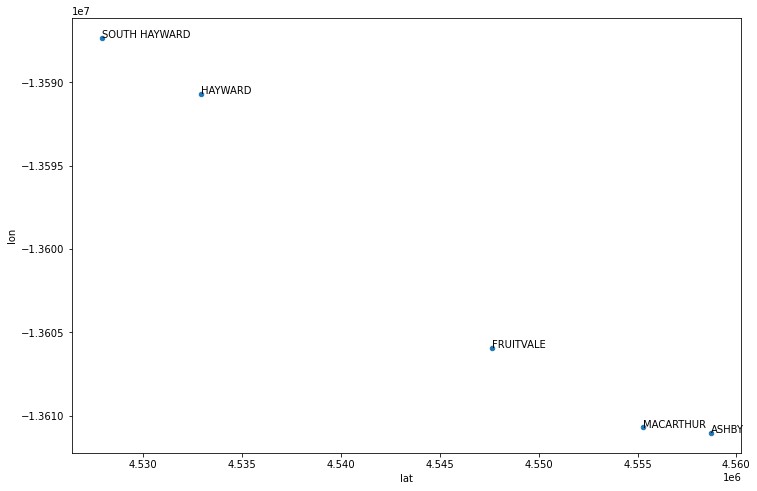

In [20]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

ax = tod.plot.scatter('lat', 'lon', figsize=(12,8))
label_point(tod['lat'], tod['lon'], tod['Station'], ax)

TypeError: __init__() got an unexpected keyword argument 'label'

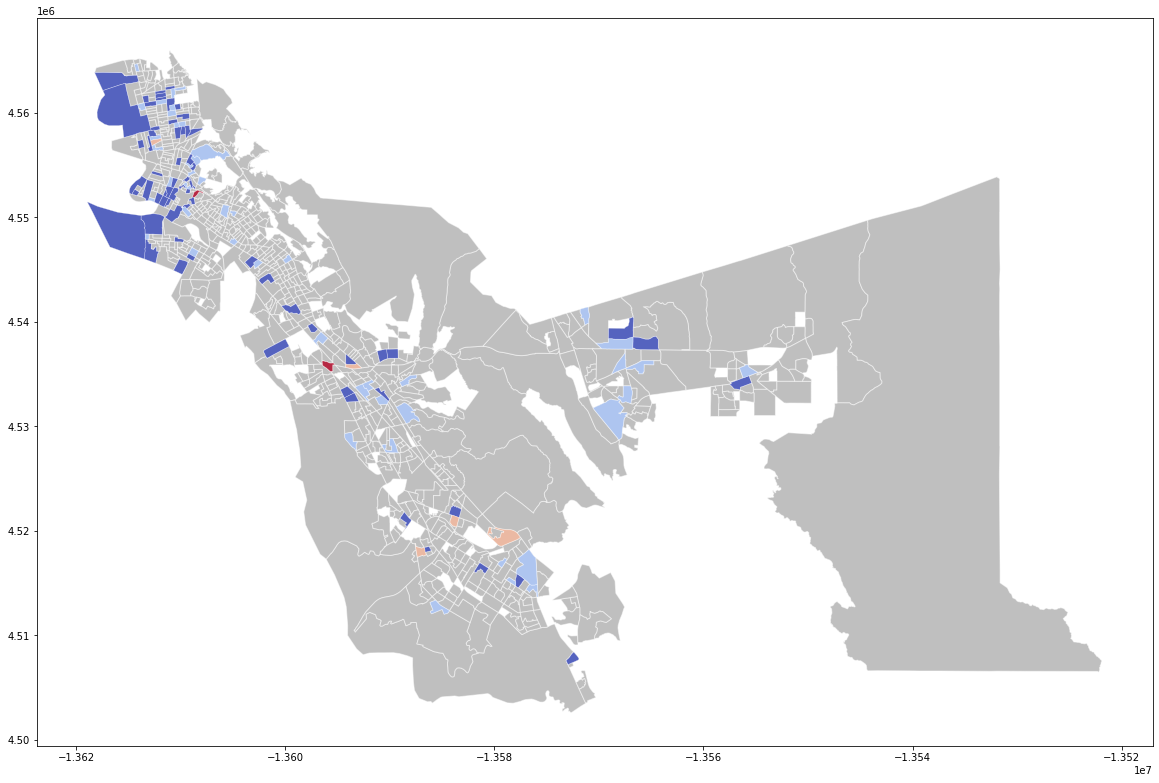

In [21]:
fig, ax = plt.subplots(figsize=(20,20))

# block groups
blkgrp_wb.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.5)

rent_b_wb.plot(ax=ax,
           column = '>30%_change',
         cmap='coolwarm', 
         edgecolor='white',
         alpha=0.8,
           scheme='user_defined',
            classification_kwds={'bins':[-2,-1, 0, 1, 2]},
            linewidth=0.3,
            legend=True,
               legend_kwds={'label': 'Percent Change','orientation': "horizontal"})
tod.plot(ax=ax,
         color = 'black',
         marker = "D",
         markersize = 15,
        label = tod.Station)

brt.plot(ax=ax,
         color = 'yellow',
         marker = "x",
         markersize = 25,
        label = brt.Station)


ax.set_xlim(minx - 2000, maxx + 2000) 
ax.set_ylim(miny - 2000, maxy + 2000)
ax.axis('off')
ax.set_title('Change in Block Groups who spend >30% of their income on rent',fontsize=15,pad=18)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

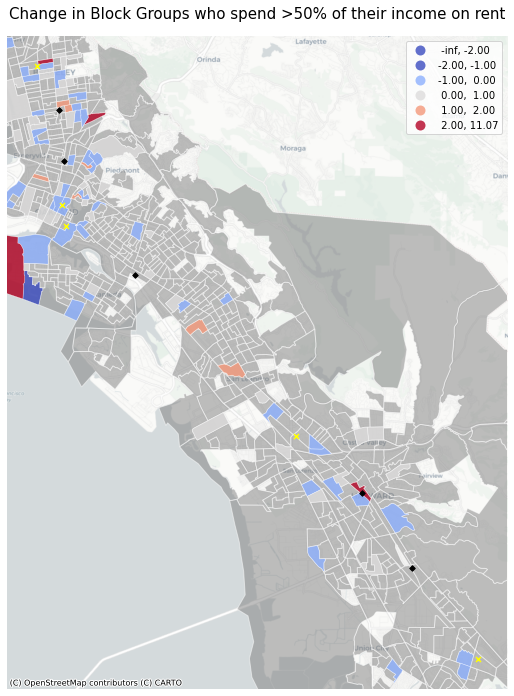

In [22]:
fig, ax = plt.subplots(figsize=(12,12))

# block groups
blkgrp_wb.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.5)

rent_b_wb.plot(ax=ax,
           column = '>50%_change',
         cmap='coolwarm', 
         edgecolor='white',
         alpha=0.8,
           scheme='user_defined',
            classification_kwds={'bins':[-2,-1, 0, 1, 2]},
            linewidth=0.3,
            legend=True)

tod.plot(ax=ax,
         color = 'black',
         marker = "D",
         markersize = 15,
        label = tod.Station)

brt.plot(ax=ax,
         color = 'yellow',
         marker = "x",
         markersize = 25,
        label = brt.Station)

ax.set_xlim(minx - 2000, maxx + 2000) 
ax.set_ylim(miny - 2000, maxy + 2000)

ax.axis('off')
ax.set_title('Change in Block Groups who spend >50% of their income on rent',fontsize=15,pad=18)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

I'm super stoked with my progress so far, but I am far from finished. I'd really like to find a way to annotate the station points on the map so the Station Name is next to the points. I'd also maybe like to create another legend for the transit points so we can see if they are TOD or not. I changed the marker for TOD vs non TOD, but people won't know that by looking at it. I also want to fix my scale and get a better basemap.

I'm going to try making maps with plotly express.

In [23]:
rent_b_wb.head()

,GEOID,Name,<10%_change,>50%_change,>30%_change,geometry
0,060014013002,"Block Group 2, Census Tract 4013, Alameda Coun...",-0.317572,0.765584,0.020955,"POLYGON ((-13611411.958 4553003.530, -13611390..."
1,060014013003,"Block Group 3, Census Tract 4013, Alameda Coun...",-0.234168,-0.489111,-0.020097,"POLYGON ((-13610925.714 4552914.477, -13610915..."
2,060014052004,"Block Group 4, Census Tract 4052, Alameda Coun...",0.599206,-0.464266,2.256566,"POLYGON ((-13608874.207 4551948.751, -13608860..."
3,060014223001,"Block Group 1, Census Tract 4223, Alameda Coun...",2.165468,11.068345,-0.502061,"POLYGON ((-13612458.250 4562016.630, -13612437..."
4,060014280002,"Block Group 2, Census Tract 4280, Alameda Coun...",-0.804639,0.954388,0.161428,"POLYGON ((-13609248.129 4546534.370, -13609238..."


In [24]:
# what's the centroid?
minx2, miny2, maxx2, maxy2 = stations_wb.geometry.total_bounds
center_lat = (maxy2-miny2)/2+miny2
center_lon = (maxx2-minx2)/2+minx2
print (center_lat)
print (center_lon)

4541719.520849999
-13597703.56975


In [25]:
type(stations_wb)

geopandas.geodataframe.GeoDataFrame